# Stem Counting in Intermediate wheatgrass
Two different programs have been used for stem (circle) detection: **OpenCV** and **Skimage**. Both rely on the Hough transform to detect circles. 

Each program was tested with an RGB image as well as a L*a*b* image with $0 \leq a* < 125$ in an integer range [0...255] as in ImageJ, or $-127 \leq a* < 0$ in an integer range [-127...127] as in the CIELAB scale.

## Dependencies

In [209]:
# CustomFunction is my own package with functions I have created to facilitate my work. It is not totally necessary for this purpose.
from CustomFunctions import *

import time
# start_time = time.time()

import os

import glob

import numpy as np

import cv2 as cv

import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter, circle_perimeter_aa
from skimage.draw import disk, set_color
from skimage.util import img_as_ubyte

from scipy import ndimage, misc
from PIL import Image

import pandas as pd

import pathlib

import numbers

import seaborn as sns

# Change the "%matplotlib inline" figure resolution on the notebook if desired
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 600

# Make sure Jupyter Notebook shows all outputs from the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Test image

In [268]:
%%time
mypath = r'./Images/Stems/Testing'
Images = glob.glob(mypath + '/**/*.JPG', recursive=True)
img0 = plt.imread(Images[0])
# plt.imshow(img0)
# print("Image ", Images[0])

Wall time: 1.07 s


## Using OpenCV
The function will detect circles on either an rgb or a Lab image. 
For an rgb image (LAB=False), a Canny edge detector will be used to identify the stems and the output will be passed to the Hough circle function. 
For a Lab image (LAB=True), Hough will be executed on the thresholded Lab given the minLAB and maxLAB values.

In [3]:
def DetectStemsCV(img, LAB=True, minLAB=[140,0,0], maxLAB=[255,125,255], FilledCircles=False):
    
    # The function will detect circles on either an rgb or a Lab image.
    # For an rgb image (LAB=False), a Canny edge detector will be passed to the Hough circle.
    # For a Lab image (LAB=True, and min and max values given as lists), Hough will be executed on the thresholded Lab given the minLAB and maxLAB values.
    
    # Read image
    if isinstance(img, str) == True:
        img = plt.imread(img)
    else: 
        img = img
    
    output = img.copy()
    
    if LAB == True and minLAB is not None and maxLAB is not None:
        LAB = cv.cvtColor(img, cv.COLOR_BGR2LAB)
        minLAB = np.array(minLAB)
        maxLAB = np.array(maxLAB)
        maskLAB = cv.inRange(LAB, minLAB, maxLAB)
        LAB = cv.bitwise_and(img, img, mask = maskLAB)
        gray = cv.cvtColor(LAB, cv.COLOR_BGR2GRAY)
        gray = cv.medianBlur(gray, 5)
        circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, dp=1, minDist=40,
                              param1=60, param2=28, minRadius=1, maxRadius=45)
    else:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        gray = cv.medianBlur(gray, 5)
        edges = cv.Canny(gray,50,150)
        circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, minDist=40,
                              param1=60, param2=28, minRadius=20, maxRadius=45)
    
    detected_circles = np.uint16(np.around(circles)) # list of circle parameters (x, y, radius)
    
    
    if FilledCircles == True:
        for (center_x, center_y, radius) in detected_circles[0, :]:
            circy, circx = disk((center_x, center_y), radius,
                                            shape=img.shape)
            set_color(output, (circx, circy), [255, 0, 0], alpha=0.5)
    else:
        for (x, y ,r) in detected_circles[0, :]:
            cv.circle(output, (x, y), r, (255, 0, 0), 2)
        

    return output, len(detected_circles[0])


Testing on RGB

In [267]:
%%time

Stems, nStems = DetectStemsCV(img0, LAB=False, minLAB=[0,0,0], maxLAB=[255,125,255], FilledCircles=False)
# plt.imshow(Stems)
print("\n", nStems, " stems identified.", "\n")

NameError: name 'img0' is not defined

Testing on LAB with a* < 125

In [269]:
%%time

Stems, nStems = DetectStemsCV(img0, LAB=True, minLAB=[0,0,0], maxLAB=[255,125,255], FilledCircles=False)
# plt.imshow(Stems)
print("\n", nStems, " stems identified.", "\n")

TypeError: cannot unpack non-iterable int object

## Using Skimage
Unlike with the OpenCV-based function, here we use a Canny detector on both the rgb and the thresholded Lab. 

We can currently change only the upper bound of the a* channel without using OpenCV. We could add parameters to change the other channels if needed but it seems to be more computationally intensive with Skimage, so we may consider using openCV ucntions such as `inRange`.

In [6]:
def DetectStems(img, MedianSize=7, CannySigma=1, CannyLow=50, CannyHigh=150, LAB=True, minLAB=[0,0,0], maxLAB=[255,125,255]):
    
    # Read image
    if isinstance(img, str) == True:
        img = plt.imread(img)
    else: 
        img = img
    
    output = img.copy()
    
    # Detect radii
    hough_radii = np.arange(20, 50, 1)
    
    if LAB == True and minLAB is not None and maxLAB is not None:
        LAB = cv.cvtColor(img, cv.COLOR_BGR2LAB)
        minLAB = np.array(minLAB)
        maxLAB = np.array(maxLAB)
        maskLAB = cv.inRange(LAB, minLAB, maxLAB)
        LAB = cv.bitwise_and(img, img, mask = maskLAB)
        gray0 = LAB @ [0.2126, 0.7152, 0.0722]
        gray0 = ndimage.median_filter(gray0, size=MedianSize)
        hough_res = hough_circle(gray0, hough_radii)
    else: 
        gray0 = img @ [0.2126, 0.7152, 0.0722]
        gray0 = ndimage.median_filter(gray0, size=MedianSize)
        edges = canny(gray0, sigma = CannySigma, low_threshold=CannyLow, high_threshold=CannyHigh)
        hough_res = hough_circle(edges, hough_radii)
    
    # Get peaks
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, min_xdistance=30, min_ydistance=30, threshold=0.34)
    
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = disk((center_y, center_x), radius, shape=output.shape)
        set_color(output, (circy, circx), [255, 0, 0], alpha=0.5)


    return output, len(radii)
    
    


Testing on RGB

In [270]:
%%time

Stems, nStems = DetectStems(img0, MedianSize = 5, CannySigma = 1, CannyLow=10, CannyHigh=80, LAB=False)
plt.imshow(Stems)
print("\n", nStems, " stems identified.", "\n")


NameError: name 'DetectStems' is not defined

Testing on LAB with a* < 0

In [271]:
%%time

Stems, nStems = DetectStems(img0, MedianSize = 5, CannySigma = 1, CannyLow=5, CannyHigh=150, LAB=True, minLAB=[100,0,0], maxLAB=[255,125,255])
plt.imshow(Stems)
print("\n", nStems, " stems identified.", "\n")

NameError: name 'DetectStems' is not defined

# Executing OpenCV's on entire images' folder

## Modify function
This is so it doesn't create images since we only care about the number of detected stems

In [132]:
def DetectStemsCV(img, LAB=True, minLAB=[100,0,0], maxLAB=[255,125,255], img_out=False, FilledCircles=False):
    
    # The function will detect circles on either an rgb or a Lab image.
    # For an rgb image (LAB=False), a Canny edge detector will be passed to the Hough circle.
    # For a Lab image (LAB=True, and min and max values given as lists), Hough will be executed on the thresholded Lab given the minLAB and maxLAB values.
    
    # Read image
    if isinstance(img, str) == True:
        img = plt.imread(img)
    else: 
        img = img
    
#     output = img.copy()
    
    if LAB == True and minLAB is not None and maxLAB is not None:
        LAB = cv.cvtColor(img, cv.COLOR_BGR2LAB)
        minLAB = np.array(minLAB)
        maxLAB = np.array(maxLAB)
        maskLAB = cv.inRange(LAB, minLAB, maxLAB)
        LAB = cv.bitwise_and(img, img, mask = maskLAB)
        gray = cv.cvtColor(LAB, cv.COLOR_BGR2GRAY)
        gray = cv.medianBlur(gray, 5)
        circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, dp=1, minDist=40,
                              param1=60, param2=28, minRadius=1, maxRadius=45)
    else:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        gray = cv.medianBlur(gray, 5)
        edges = cv.Canny(gray,50,150)
        circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, minDist=40,
                              param1=60, param2=28, minRadius=20, maxRadius=45)
    
    detected_circles = np.uint16(np.around(circles)) # list of circle parameters (x, y, radius)
    
    if img_out == False:
        return len(detected_circles[0])
    else:
        if FilledCircles == True:
            for(center_x, center_y, radius) in detected_circles[0, :]:
                circy, circx = disk((center_x, center_y), radius,
                                                shape=img.shape)
                set_color(output, (circx, circy), [255, 0, 0], alpha=0.5)
        else:
            for (x, y ,r) in detected_circles[0, :]:
                cv.circle(output, (x, y), r, (255, 0, 0), 2)
        
        return output, len(detected_circles[0])


## Images' Folder

In [134]:
# Define image folder
mypath = r'./Images/Stems/Original'
Images = glob.glob(mypath + '/*.JPG', recursive=False)
# Images[0:5]

## Column Names
The idea here is to see how many stemes we detect when we change one variable at a time and keep the others constant. We will start by changing min and max LAB values.
By looking at different LAB thresholds in FIJI, I found the following to be the most interesting starting parameters:

| Channel | Min | Max | Step | Variables |
| --- | :-: | :-: | :-: | :-: |
| L | 80 | 255 | 20 | 7 |
| A | 0 | 150 | 10 | 17 |
| B | 100 | 160 | 30 | 3 |

This will result in total of 357 variables (7x17x3)


In [169]:
# Define MAX values
# Use the unpacking operator *
L = [*range(80, 255, 20), 255]
# L = [141, 255]
L

A = [*range(100, 150, 15)]
# A = [0, 150, 10]
A

B = [*range(100, 200, 30)]
B

TotVars = len(L) * len(A) * len(B)
TotVars

[80, 100, 120, 140, 160, 180, 200, 220, 240, 255]

[100, 115, 130, 145]

[100, 130, 160, 190]

160

In [170]:
# Fixed values
minL = 80
minA = 0
minB = 100

# Fluctuating values
maxL = L * len(A) * len(B)
maxL.sort()
# maxL

maxA = [x for x in A * (len(L) * len(B)) ]
# maxA.sort()
# maxA

maxB = B * (len(A))
maxB.sort()
maxB = maxB * len(L)

df = pd.DataFrame(list(zip(maxL, maxA, maxB)),
               columns =['maxL', 'maxA', 'maxB'])

df['VarName'] = 'v_' + df['maxL'].astype(str) + '_' + df['maxA'].astype(str) + '_' + df['maxB'].astype(str) 

df

maxL  maxA  maxB        VarName
0      80   100   100   v_80_100_100
1      80   115   100   v_80_115_100
2      80   130   100   v_80_130_100
3      80   145   100   v_80_145_100
4      80   100   130   v_80_100_130
..    ...   ...   ...            ...
155   255   145   160  v_255_145_160
156   255   100   190  v_255_100_190
157   255   115   190  v_255_115_190
158   255   130   190  v_255_130_190
159   255   145   190  v_255_145_190

[160 rows x 4 columns]

## Execution

In [173]:
%%time

Stems_data = pd.DataFrame()

for img in Images:

    # Image name (barcode)
    img_name = img.split("\\")[-1]
    img_name = img_name.replace(".JPG", "")
    
    print('Image: ', img_name)

    # nStems per variable
    TotStems = []

    for i in range(TotVars):

        # Index the row
        Values = df.iloc[i]
        
        # Restart
        nStems = 0
        
        print(Values[0], Values[1], Values[2])
#         print(nStems)
        
        try:
            # Create output image and get number of detected stems
            nStems = DetectStemsCV(img, LAB=True, minLAB=[minL,minA,minB], maxLAB=[Values[0], Values[1], Values[2]], img_out=False)
        except: 
            pass

        TotStems.append(nStems)
    
    
    #----------------- RGB --------------------
    # Restart
    nStems = 0
    try:
        # Create output image and get number of detected stems
        nStems = DetectStemsCV(img, LAB=False, minLAB=[0,0,0], maxLAB=[Values[0], Values[1], Values[2]], img_out=False)
    except: 
        pass
    TotStems.append(nStems)
    
    # Values for current image
    Stems_data[img_name] = TotStems
        



Image:  5144
80 100 100
80 115 100
80 130 100
80 145 100
80 100 130
80 115 130
80 130 130
80 145 130
80 100 160
80 115 160
80 130 160
80 145 160
80 100 190
80 115 190
80 130 190
80 145 190
100 100 100
100 115 100
100 130 100
100 145 100
100 100 130
100 115 130
100 130 130
100 145 130
100 100 160
100 115 160
100 130 160
100 145 160
100 100 190
100 115 190
100 130 190
100 145 190
120 100 100
120 115 100
120 130 100
120 145 100
120 100 130
120 115 130
120 130 130
120 145 130
120 100 160
120 115 160
120 130 160
120 145 160
120 100 190
120 115 190
120 130 190
120 145 190
140 100 100
140 115 100
140 130 100
140 145 100
140 100 130
140 115 130
140 130 130
140 145 130
140 100 160
140 115 160
140 130 160
140 145 160
140 100 190
140 115 190
140 130 190
140 145 190
160 100 100
160 115 100
160 130 100
160 145 100
160 100 130
160 115 130
160 130 130
160 145 130
160 100 160
160 115 160
160 130 160
160 145 160
160 100 190
160 115 190
160 130 190
160 145 190
180 100 100
180 115 100
180 130 100
180 145

## Data File

In [196]:
%%time
Vars = list(df.iloc[:,-1])
Vars.append('RGB')
# Vars
Stems_data2 = Stems_data.set_axis(Vars, axis = 0)
Stems_data2 = Stems_data2.T
Stems_data2['barcode'] = Stems_data2.index
Stems_data2.insert(0, 'barcode', Stems_data2.pop('barcode'))
Stems_data2

Wall time: 6.02 ms


barcode  v_80_100_100  v_80_115_100  v_80_130_100  v_80_145_100  \
5144      5144             0             0             0             0   
B_0435  B_0435             0             0             0             0   
5246      5246             0             0             0             0   
5234      5234             0             0             0             0   
5162      5162             0             0             0             0   
...        ...           ...           ...           ...           ...   
0049      0049             0             0             0             0   
0051      0051             0             0             0             0   
0545      0545             0             0             0             0   
0016      0016             0             0             0             0   
0099      0099             0             0             0             0   

        v_80_100_130  v_80_115_130  v_80_130_130  v_80_145_130  v_80_100_160  \
5144               0             0             0             0             0   
B_0435             0             0             0             0             0   
5246               0             0             0             0             0   
5234               0             0             0             0             0   
5162               0             0             0             0             0   
...              ...           ...           ...           ...           ...   
0049               0             0             0             0             0   
0051               0             0             0             0             0   
0545               0             0             0             0             0   
0016               0             0             0             0             0   
0099               0             0             0             0             0   

        ...  v_255_145_130  v_255_100_160  v_255_115_160  v_255_130_160  \
5144    ...             50             16             86             97   
B_0435  ...             46             31            112            132   
5246    ...             44            120            203            203   
5234    ...             14              0              6             54   
5162    ...              0              0              1              5   
...     ...            ...            ...            ...            ...   
0049    ...            234             14            191            247   
0051    ...             32              7             44             70   
0545    ...            117              6            142            148   
0016    ...             36              0             32            104   
0099    ...             55              0             14             79   

        v_255_145_160  v_255_100_190  v_255_115_190  v_255_130_190  \
5144               96             16             86             97   
B_0435            131             31            112            132   
5246              200            120            203            203   
5234               69              0              6             54   
5162                5              0              1              5   
...               ...            ...            ...            ...   
0049              247             14            191            247   
0051               73              7             44             70   
0545              147              6            142            148   
0016              112              0             32            104   
0099               91              0             14             79   

        v_255_145_190  RGB  
5144               96   92  
B_0435            131  106  
5246              200  209  
5234               69   60  
5162                5    5  
...               ...  ...  
0049              247  203  
0051               73   52  
0545              147  142  
0016              112   91  
0099               91   56  

[100 rows x 162 columns]

## Export File

In [180]:
data_name = ".\\Images\\Stems\\Original\\StemsStems09072021.csv"
Stems_data2.to_csv(data_name, index=False)

# Merge with Automatic Count

## Import Manual Count

In [211]:
MC = pd.read_excel(".\\IWG_stems_100_v2.xlsx", engine='openpyxl')
MC

barcode  loc  year  manual_tiller_ct
0        16  STP  2018                94
1        19  STP  2018                90
2        48  STP  2018               164
3        49  STP  2018               183
4        50  STP  2018               143
..      ...  ...   ...               ...
95     1255  STP  2018               186
96     5162  STP  2018                 5
97     5144  STP  2018                91
98     5234  STP  2018                58
99     5246  STP  2018               207

[100 rows x 4 columns]

In [212]:
# Automatic Count (AC)
AC = Stems_data2
AC['barcode'] = AC['barcode'].str.replace(r'B_', '')
AC["barcode"] = pd.to_numeric(AC["barcode"])
AC

AttributeError: Can only use .str accessor with string values!

In [213]:
df1 = pd.merge(AC, MC, on = ['barcode'])
df1

barcode  v_80_100_100  v_80_115_100  v_80_130_100  v_80_145_100  \
0      5144             0             0             0             0   
1       435             0             0             0             0   
2      5246             0             0             0             0   
3      5234             0             0             0             0   
4      5162             0             0             0             0   
..      ...           ...           ...           ...           ...   
95       49             0             0             0             0   
96       51             0             0             0             0   
97      545             0             0             0             0   
98       16             0             0             0             0   
99       99             0             0             0             0   

    v_80_100_130  v_80_115_130  v_80_130_130  v_80_145_130  v_80_100_160  ...  \
0              0             0             0             0             0  ...   
1              0             0             0             0             0  ...   
2              0             0             0             0             0  ...   
3              0             0             0             0             0  ...   
4              0             0             0             0             0  ...   
..           ...           ...           ...           ...           ...  ...   
95             0             0             0             0             0  ...   
96             0             0             0             0             0  ...   
97             0             0             0             0             0  ...   
98             0             0             0             0             0  ...   
99             0             0             0             0             0  ...   

    v_255_130_160  v_255_145_160  v_255_100_190  v_255_115_190  v_255_130_190  \
0              97             96             16             86             97   
1             132            131             31            112            132   
2             203            200            120            203            203   
3              54             69              0              6             54   
4               5              5              0              1              5   
..            ...            ...            ...            ...            ...   
95            247            247             14            191            247   
96             70             73              7             44             70   
97            148            147              6            142            148   
98            104            112              0             32            104   
99             79             91              0             14             79   

    v_255_145_190  RGB  loc  year  manual_tiller_ct  
0              96   92  STP  2018                91  
1             131  106  STP  2018               121  
2             200  209  STP  2018               207  
3              69   60  STP  2018                58  
4               5    5  STP  2018                 5  
..            ...  ...  ...   ...               ...  
95            247  203  STP  2018               183  
96             73   52  STP  2018                54  
97            147  142  STP  2018               149  
98            112   91  STP  2018                94  
99             91   56  STP  2018                79  

[100 rows x 165 columns]

In [214]:
# Move manual count to front
mc = df1['manual_tiller_ct']
df1.drop(labels=['manual_tiller_ct'], axis=1,inplace = True)
df1.insert(1, 'manual_tiller_ct', mc)
df1

barcode  manual_tiller_ct  v_80_100_100  v_80_115_100  v_80_130_100  \
0      5144                91             0             0             0   
1       435               121             0             0             0   
2      5246               207             0             0             0   
3      5234                58             0             0             0   
4      5162                 5             0             0             0   
..      ...               ...           ...           ...           ...   
95       49               183             0             0             0   
96       51                54             0             0             0   
97      545               149             0             0             0   
98       16                94             0             0             0   
99       99                79             0             0             0   

    v_80_145_100  v_80_100_130  v_80_115_130  v_80_130_130  v_80_145_130  ...  \
0              0             0             0             0             0  ...   
1              0             0             0             0             0  ...   
2              0             0             0             0             0  ...   
3              0             0             0             0             0  ...   
4              0             0             0             0             0  ...   
..           ...           ...           ...           ...           ...  ...   
95             0             0             0             0             0  ...   
96             0             0             0             0             0  ...   
97             0             0             0             0             0  ...   
98             0             0             0             0             0  ...   
99             0             0             0             0             0  ...   

    v_255_115_160  v_255_130_160  v_255_145_160  v_255_100_190  v_255_115_190  \
0              86             97             96             16             86   
1             112            132            131             31            112   
2             203            203            200            120            203   
3               6             54             69              0              6   
4               1              5              5              0              1   
..            ...            ...            ...            ...            ...   
95            191            247            247             14            191   
96             44             70             73              7             44   
97            142            148            147              6            142   
98             32            104            112              0             32   
99             14             79             91              0             14   

    v_255_130_190  v_255_145_190  RGB  loc  year  
0              97             96   92  STP  2018  
1             132            131  106  STP  2018  
2             203            200  209  STP  2018  
3              54             69   60  STP  2018  
4               5              5    5  STP  2018  
..            ...            ...  ...  ...   ...  
95            247            247  203  STP  2018  
96             70             73   52  STP  2018  
97            148            147  142  STP  2018  
98            104            112   91  STP  2018  
99             79             91   56  STP  2018  

[100 rows x 165 columns]

# Plotting

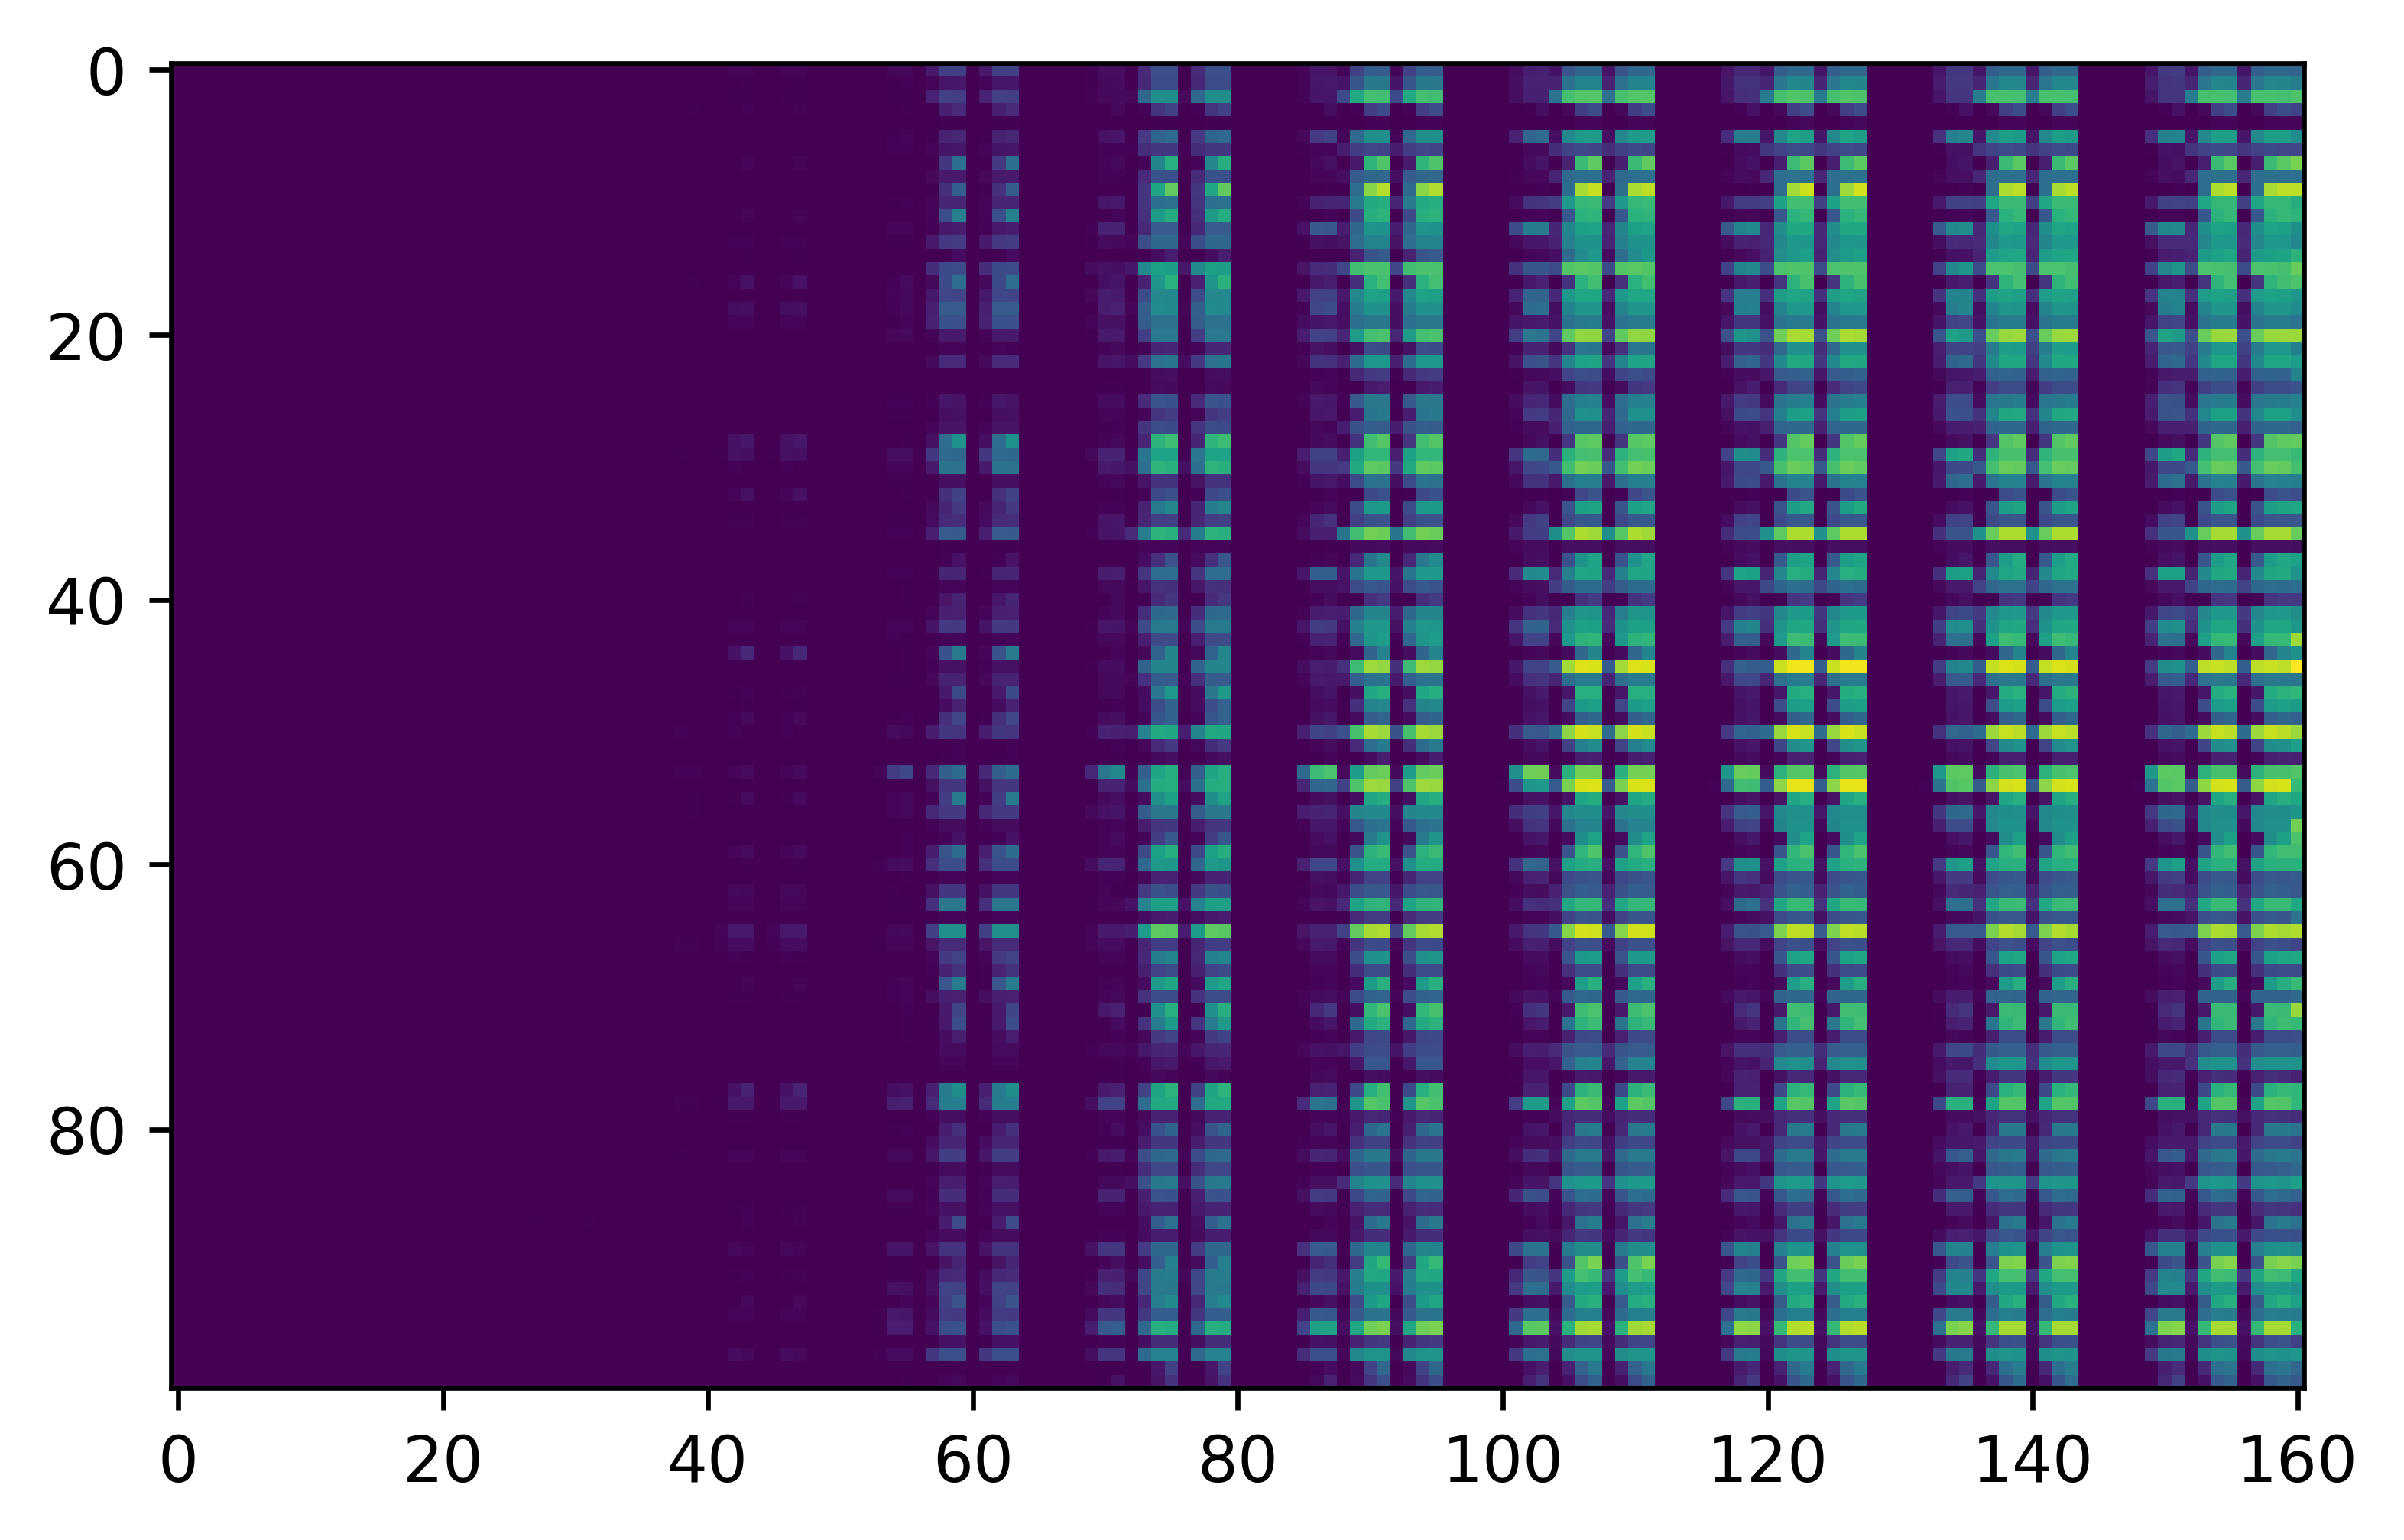

In [241]:
# Select data to plot (dtp)
dtp = df1.iloc[:,2:162]
dtp['manual_tiller_ct'] = df1['manual_tiller_ct']
df_img = np.asarray(dtp)

plt.imshow(df_img)

# sns.pairplot(dtp)

In [207]:
df1.iloc[:,1:5]

manual_tiller_ct  v_80_100_100  v_80_115_100  v_80_130_100
0                 91             0             0             0
1                121             0             0             0
2                207             0             0             0
3                 58             0             0             0
4                  5             0             0             0
..               ...           ...           ...           ...
95               183             0             0             0
96                54             0             0             0
97               149             0             0             0
98                94             0             0             0
99                79             0             0             0

[100 rows x 4 columns]

In [216]:
df1.iloc[:,20:50]

v_100_130_100  v_100_145_100  v_100_100_130  v_100_115_130  v_100_130_130  \
0               0              0              0              0              0   
1               0              0              0              0              0   
2               0              0              0              0              0   
3               0              0              0              0              0   
4               0              0              0              0              0   
..            ...            ...            ...            ...            ...   
95              0              0              0              0              0   
96              0              0              0              0              0   
97              0              0              0              0              0   
98              0              0              0              0              0   
99              0              0              0              0              0   

    v_100_145_130  v_100_100_160  v_100_115_160  v_100_130_160  v_100_145_160  \
0               0              0              0              0              0   
1               0              0              0              0              0   
2               0              0              0              0              0   
3               0              0              0              0              0   
4               0              0              0              0              0   
..            ...            ...            ...            ...            ...   
95              0              0              0              0              0   
96              0              0              0              0              0   
97              0              0              0              0              0   
98              0              0              0              0              0   
99              0              0              0              0              0   

    ...  v_120_130_130  v_120_145_130  v_120_100_160  v_120_115_160  \
0   ...              1              1              0              0   
1   ...              0              1              0              0   
2   ...              0              0              0              1   
3   ...              1              2              0              0   
4   ...              0              0              0              0   
..  ...            ...            ...            ...            ...   
95  ...              1              0              0              0   
96  ...              0              0              0              0   
97  ...              1              1              0              0   
98  ...              0              0              0              0   
99  ...              0              1              0              0   

    v_120_130_160  v_120_145_160  v_120_100_190  v_120_115_190  v_120_130_190  \
0               4              4              0              0              4   
1               1              2              0              0              1   
2               2              2              0              1              2   
3               0              3              0              0              0   
4               0              0              0              0              0   
..            ...            ...            ...            ...            ...   
95              1              1              0              0              1   
96              1              1              0              0              1   
97              9              7              0              0              9   
98              0              0              0              0              0   
99              0              1              0              0              0   

    v_120_145_190  
0               4  
1               2  
2               2  
3               3  
4               0  
..            ...  
95              1  
96              1  
97              7  
98              0  
99          

In [243]:
test = df1
test = test.replace({'0':np.nan, 0:np.nan})
test

barcode  manual_tiller_ct  v_80_100_100  v_80_115_100  v_80_130_100  \
0    5144.0              91.0           NaN           NaN           NaN   
1     435.0             121.0           NaN           NaN           NaN   
2    5246.0             207.0           NaN           NaN           NaN   
3    5234.0              58.0           NaN           NaN           NaN   
4    5162.0               5.0           NaN           NaN           NaN   
..      ...               ...           ...           ...           ...   
95     49.0             183.0           NaN           NaN           NaN   
96     51.0              54.0           NaN           NaN           NaN   
97    545.0             149.0           NaN           NaN           NaN   
98     16.0              94.0           NaN           NaN           NaN   
99     99.0              79.0           NaN           NaN           NaN   

    v_80_145_100  v_80_100_130  v_80_115_130  v_80_130_130  v_80_145_130  ...  \
0            NaN           NaN           NaN           NaN           NaN  ...   
1            NaN           NaN           NaN           NaN           NaN  ...   
2            NaN           NaN           NaN           NaN           NaN  ...   
3            NaN           NaN           NaN           NaN           NaN  ...   
4            NaN           NaN           NaN           NaN           NaN  ...   
..           ...           ...           ...           ...           ...  ...   
95           NaN           NaN           NaN           NaN           NaN  ...   
96           NaN           NaN           NaN           NaN           NaN  ...   
97           NaN           NaN           NaN           NaN           NaN  ...   
98           NaN           NaN           NaN           NaN           NaN  ...   
99           NaN           NaN           NaN           NaN           NaN  ...   

    v_255_115_160  v_255_130_160  v_255_145_160  v_255_100_190  v_255_115_190  \
0            86.0           97.0           96.0           16.0           86.0   
1           112.0          132.0          131.0           31.0          112.0   
2           203.0          203.0          200.0          120.0          203.0   
3             6.0           54.0           69.0            NaN            6.0   
4             1.0            5.0            5.0            NaN            1.0   
..            ...            ...            ...            ...            ...   
95          191.0          247.0          247.0           14.0          191.0   
96           44.0           70.0           73.0            7.0           44.0   
97          142.0          148.0          147.0            6.0          142.0   
98           32.0          104.0          112.0            NaN           32.0   
99           14.0           79.0           91.0            NaN           14.0   

    v_255_130_190  v_255_145_190    RGB  loc    year  
0            97.0           96.0   92.0  STP  2018.0  
1           132.0          131.0  106.0  STP  2018.0  
2           203.0          200.0  209.0  STP  2018.0  
3            54.0           69.0   60.0  STP  2018.0  
4             5.0            5.0    5.0  STP  2018.0  
..            ...            ...    ...  ...     ...  
95          247.0          247.0  203.0  STP  2018.0  
96           70.0           73.0   52.0  STP  2018.0  
97          148.0          147.0  142.0  STP  2018.0  
98          104.0          112.0   91.0  STP  2018.0  
99           79.0           91.0   56.0  STP  2018.0  

[100 rows x 165 columns]

In [266]:
# Data to correlate
dtc = df1.iloc[:,2:162]
dtc = dtc.replace({'0':np.nan, 0:np.nan})
dtc = dtc.dropna(thresh=80, axis=1)
# dtc
Corrs = dtc.corrwith(df1['manual_tiller_ct'])
Corrs
len(Corrs)

v_140_145_130    0.176196
v_140_130_160    0.435467
v_140_145_160    0.492468
v_140_130_190    0.435372
v_140_145_190    0.492116
v_160_130_130    0.278908
v_160_145_130    0.269870
v_160_115_160    0.445765
v_160_130_160    0.742641
v_160_145_160    0.777589
v_160_115_190    0.446251
v_160_130_190    0.743569
v_160_145_190    0.777615
v_180_130_130    0.302688
v_180_145_130    0.305319
v_180_115_160    0.532301
v_180_130_160    0.898585
v_180_145_160    0.916552
v_180_115_190    0.532405
v_180_130_190    0.899402
v_180_145_190    0.917116
v_200_130_130    0.338401
v_200_145_130    0.340273
v_200_115_160    0.594269
v_200_130_160    0.931889
v_200_145_160    0.944513
v_200_115_190    0.595476
v_200_130_190    0.931711
v_200_145_190    0.944318
v_220_130_130    0.352588
v_220_145_130    0.355643
v_220_115_160    0.596238
v_220_130_160    0.936776
v_220_145_160    0.949684
v_220_115_190    0.597597
v_220_130_190    0.937248
v_220_145_190    0.950065
v_240_130_130    0.354860
v_240_145_13

53

In [172]:
1.6*100/2



80.0

# Older Excecution

In [21]:
%%time

Stems_data = pd.DataFrame()

# CountColname = "LABa0-140"
CountColname = "RGB_v01"

for img in Images:
    
    # Read the image
    img0 = iio.imread(img)
#     img0 = CropStems(img)
    
    # Create output image and get number of detected stems
    Stems, nStems = DetectStemsCV(img0, LAB=False, minLAB=[0,0,0], maxLAB=[255,140,255], FilledCircles=False)
    
    # Create path to nested subdirectory for output image
    FullPath = img.split("\\")[:1]
    FullPath = '\\'.join([str(i) for i in FullPath])
    FullPath = FullPath + "\\DetectedStems\\"
    output_name = img.split("\\")[-1]
    barcode = output_name.replace(".JPG", "")
    barcode = barcode.split("_")[-1]
    output_name = output_name.replace(".JPG", "_DC.JPG")
    
    # Check if folder exist, create otherwise
    path = pathlib.Path(FullPath)
    path.mkdir(parents=True, exist_ok=True)
    
    # Define full filename and save image
    output_name = FullPath + output_name
    imgWritten = cv.imwrite(output_name, cv.cvtColor(Stems, cv.COLOR_RGB2BGR))
    
    if imgWritten:
          print("Image saved as ", output_name)
    
    img_data = pd.DataFrame([(int(barcode), nStems)], columns=["barcode",CountColname])
    Stems_data = Stems_data.append(img_data)
    

Image saved as  ./Images/Stems/Original\DetectedStems\5144_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\B_0435_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\5246_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\5234_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\5162_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\1193_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\1163_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\1243_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\1202_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\1237_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\1234_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\1255_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\1183_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\1174_DC.JPG
Image saved as  ./Images/Stems/Original\DetectedStems\1171_DC.JPG
Image sa

## Datasets

In [22]:
Stems_data
Stems_data2 = Stems_data.reset_index()
Stems_data2
# data_name = FullPath + "Stems_data.csv"
# Stems_data.to_csv(data_name, index=False)

barcode  RGB_v01
0      5144       92
0       435      106
0      5246      209
0      5234       60
0      5162        5
..      ...      ...
0        49      203
0        51       52
0       545      142
0        16       91
0        99       56

[100 rows x 2 columns]

index  barcode  RGB_v01
0       0     5144       92
1       0      435      106
2       0     5246      209
3       0     5234       60
4       0     5162        5
..    ...      ...      ...
95      0       49      203
96      0       51       52
97      0      545      142
98      0       16       91
99      0       99       56

[100 rows x 3 columns]

In [26]:
# Read manual count file
MC = pd.read_excel(".\\IWG_stems_100.xlsx", engine='openpyxl')
MC
# MC['barcode'] = MC['barcode'].apply(lambda x: x if pd.isnull(x) else str(int(x)))
# MC

barcode  loc  year  manual_tiller_ct
0        16  STP  2018                94
1        19  STP  2018                90
2        48  STP  2018               164
3        49  STP  2018               183
4        50  STP  2018               143
..      ...  ...   ...               ...
95     1255  STP  2018               186
96     5162  STP  2018                 5
97     5144  STP  2018                91
98     5234  STP  2018                58
99     5246  STP  2018               207

[100 rows x 4 columns]

In [27]:
# Merge manual and automatic count
df1 = pd.merge(Stems_data2, MC, on = ['barcode'])
df1
# df1 = pd.concat([Stems_data2, MC], axis=0, ignore_index=True, sort=False)

# df1 = Stems_data.join(MC, how='left', lsuffix='_left', rsuffix='_right')
# df1

# df1.dropna(subset = ["LABa0-140"], inplace=True)
# df1
# data_name = FullPath + "df1.csv"
# df1.to_csv(data_name, index=False)


index  barcode  RGB_v01  loc  year  manual_tiller_ct
0       0     5144       92  STP  2018                91
1       0      435      106  STP  2018               121
2       0     5246      209  STP  2018               207
3       0     5234       60  STP  2018                58
4       0     5162        5  STP  2018                 5
..    ...      ...      ...  ...   ...               ...
95      0       49      203  STP  2018               183
96      0       51       52  STP  2018                54
97      0      545      142  STP  2018               149
98      0       16       91  STP  2018                94
99      0       99       56  STP  2018                79

[100 rows x 6 columns]

In [19]:
# df1.columns
# df2 = df1[['index', 'barcode', 'LABa0-140','manual_tiller_ct', 'rep']]
# df2

Index(['index', 'barcode', 'LABa0-140', 'famID', 'parent', 'plantID',
       'plantID3', 'longID', 'loc', 'year', 'rep', 'row', 'col', 'self',
       'manual_tiller_ct'],
      dtype='object')

index barcode  LABa0-140  manual_tiller_ct  rep
0     0.0    5144       94.0               NaN  NaN
1     0.0     435      136.0               NaN  NaN
2     0.0    5246      206.0               NaN  NaN
3     0.0    5234       76.0               NaN  NaN
4     0.0    5162        6.0               NaN  NaN
..    ...     ...        ...               ...  ...
95    0.0      49      266.0               NaN  NaN
96    0.0      51       76.0               NaN  NaN
97    0.0     545      151.0               NaN  NaN
98    0.0      16      119.0               NaN  NaN
99    0.0      99       97.0               NaN  NaN

[100 rows x 5 columns]

## Plotting

In [28]:
# df3 = df2.dropna(subset = ["rep"], inplace=True)
# df3

# Change the "%matplotlib inline" figure resolution on the notebook if desired
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

import plotnine as p9

In [ ]:
df3 = df2[['barcode','rep']]
p = p9.ggplot(data=df3, mapping=p9.aes(x='rep', y='barcode'))
# Draw the plot
p + p9.geom_point()

In [29]:
df2 = df1[['RGB_v01','manual_tiller_ct']]
df2.corr()


RGB_v01  manual_tiller_ct
RGB_v01           1.000000          0.854548
manual_tiller_ct  0.854548          1.000000

# Ignore anything below here

In [ ]:
blurry = filters.gaussian(edge_sobel, sigma = 5)
plt.imshow(blurry)

In [ ]:
# sk = skeletonize(img1 > 20)
# plt.imshow(sk, cmap='gray')

In [ ]:
# img = cv.imread('messi5.jpg',0)
blur = cv.medianBlur(img0,7)
edges = cv.Canny(blur,100,200)
plt.imshow(edges)
# blur = cv.medianBlur(edges,3)
# plt.imshow(blur)

In [ ]:
def DetectStemsCV(img, LAB=True, minLAB=[140,0,0], maxLAB=[255,125,255], FilledCircles=False):
    
    # The function will detect circles on either an rgb or a Lab image.
    # For an rgb image (LAB=False), a Canny edge detector will be passed to the Hough circle.
    # For a Lab image (LAB=True, and min and max values given as lists), Hough will be executed on the thresholded Lab given the minLAB and maxLAB values.
    
    output = img.copy()
    
    if LAB == True and minLAB is not None and maxLAB is not None:
        LAB = cv.cvtColor(img, cv.COLOR_BGR2LAB)
        minLAB = np.array(minLAB)
        maxLAB = np.array(maxLAB)
        maskLAB = cv.inRange(LAB, minLAB, maxLAB)
        LAB = cv.bitwise_and(img, img, mask = maskLAB)
        gray = cv.cvtColor(LAB, cv.COLOR_BGR2GRAY)
        gray = cv.medianBlur(gray, 5)
        circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, dp=1, minDist=50,
                              param1=60, param2=28, minRadius=20, maxRadius=45)
    else:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        gray = cv.medianBlur(gray, 5)
        edges = cv.Canny(gray,50,150)
        circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, minDist=50,
                              param1=60, param2=28, minRadius=20, maxRadius=45)
    
    detected_circles = np.uint16(np.around(circles)) # list of circle parameters (x, y, radius)
    
    
    if FilledCircles == True:
        for (center_x, center_y, radius) in detected_circles[0, :]:
            circy, circx = disk((center_x, center_y), radius,
                                            shape=img.shape)
            set_color(output, (circx, circy), [255, 0, 0], alpha=0.5)
    else:
        for (x, y ,r) in detected_circles[0, :]:
            cv.circle(output, (x, y), r, (255, 0, 0), 3)
        

    return output, detected_circles


In [ ]:
test_hc, test_dc = DetectStemsCV(img0, LAB=True, minLAB=[0,0,0], maxLAB=[255,125,255], FilledCircles=False)
plt.imshow(test_hc)
len(test_dc[0])

In [ ]:
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, minDist=50,
                              param1=60, param2=28, minRadius=40, maxRadius=60)
# len(circles[0])
detected_circles = np.uint16(np.around(circles))
for (center_y, center_x, radius) in detected_circles[0, :]:
    print(center_y, center_x, radius)


# for center_y, center_x, radius in zip(cy, cx, radii):
#         circy, circx = disk((center_y, center_x), radius,
#                                         shape=image.shape)
#         set_color(image, (circy, circx), [255, 0, 0], alpha=0.5)
# #         image[circy, circx] = (255,0,0)

#     return image, len(radii)

In [ ]:
lab_image = cv.cvtColor(img0, cv.COLOR_BGR2LAB)
l_channel,a_channel,b_channel = cv.split(lab_image)
plt.imshow(lab_image)

In [ ]:
a_channel.max()

In [ ]:
# lab = cv.cvtColor(img0, cv.COLOR_BGR2LAB)\thresh = 40
lab = cv.cvtColor(img0, cv.COLOR_BGR2LAB)
# plt.imshow(lab[:,:,1])
# hsv = [65, 229, 158]
minLAB = np.array([140, 0, 0])
maxLAB = np.array([255, 125, 255])

maskLAB = cv.inRange(lab, minLAB, maxLAB)
resultLAB = cv.bitwise_and(img0, img0, mask = maskLAB)
plt.imshow(resultLAB)
# minHSV.shape

In [ ]:
gray = cv.cvtColor(resultLAB, cv.COLOR_BGR2GRAY)
plt.imshow(gray)

In [ ]:
gray = cv.cvtColor(img0, cv.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [ ]:
ComparePlots(1,2, [test_hc, img0])

In [ ]:
len(test_dc[0])

In [ ]:
test_dc[:, 0, 0]

In [ ]:
test_hc, test_dc = hough_circle(img0, 70, 40)
bw0 = test_hc[:, :, 0] == 255
plt.imshow(bw0)

In [ ]:
edges = canny(img1,low_threshold=50, high_threshold=150)
plt.imshow(edges)

In [ ]:
# Detect two radii
hough_radii = np.arange(20, 35, 1)
hough_res = hough_circle(edges, hough_radii)

In [ ]:
hough_res.shape

In [ ]:
# hough_radii
# hough_res

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, min_xdistance=40, min_ydistance=40)

In [ ]:
len(radii)

In [ ]:
# # Draw them
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
# image = color.gray2rgb(img1)
# for center_y, center_x, radius in zip(cy, cx, radii):
#     circy, circx = disk((center_y, center_x), radius,
#                                     shape=image.shape)
    
#     image[circy, circx] = (255,0,0)

# ax.imshow(image, cmap=plt.cm.gray)
# plt.show()

# # plt.imshow(image)


# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(img1)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = disk((center_y, center_x), radius,
                                    shape=image.shape)
    set_color(image, (circy, circx), [255, 0, 0], alpha=0.5)
    
#     image[circy, circx] = (255,0,0)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

# >>> from skimage.draw import circle_perimeter_aa
# >>> img = np.zeros((10, 10), dtype=np.uint8)
# >>> rr, cc, val = circle_perimeter_aa(4, 4, 3)
# >>> img[rr, cc] = val * 255
# >>> img
# array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
#        [  0,   0,  60, 211, 255, 211,  60,   0,   0,   0],
#        [  0,  60, 194,  43,   0,  43, 194,  60,   0,   0],
#        [  0, 211,  43,   0,   0,   0,  43, 211,   0,   0],
#        [  0, 255,   0,   0,   0,   0,   0, 255,   0,   0],
#        [  0, 211,  43,   0,   0,   0,  43, 211,   0,   0],
#        [  0,  60, 194,  43,   0,  43, 194,  60,   0,   0],
#        [  0,   0,  60, 211, 255, 211,  60,   0,   0,   0],
#        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
#        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=uint8)

# >>> from skimage import data, draw
# >>> image = data.chelsea()
# >>> rr, cc, val = draw.circle_perimeter_aa(r=100, c=100, radius=75)
# >>> draw.set_color(image, (rr, cc), [1, 0, 0], alpha=val)

In [ ]:
len(radii)

In [ ]:
ComparePlots(1,2, [test_hc, img0])

In [ ]:
len(radii)

In [ ]:
def hough_circle_cv(img, min_dist, max_radius):
    output = img.copy()
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # img2 = np.floor(img)
    # img2 = img2.astype(int)
    gray = cv.medianBlur(gray, 5)
    edges = cv.Canny(gray,50,150)
    circles = cv.HoughCircles(edges, cv.HOUGH_GRADIENT, 1, min_dist,
                              param1=50, param2=30, minRadius=0, maxRadius=max_radius)
    detected_circles = np.uint16(np.around(circles)) # its a list of circle parameters (x, y ,radius)
    for (x, y ,r) in detected_circles[0, :]:
        cv.circle(output, (x, y), r, (255, 0, 0), -1)
        # cv.circle(output, (x, y), 0, (0, 255, 0), 3)
        
    return output, detected_circles # output is the orig image with cirlcles drawn on it


In [ ]:
def DetectStems(ImagePath, MedianSize = 7, CannySigma = 1, CannyLow = 50, CannyHigh = 150):
    
#     edges = canny(img1,low_threshold=50, high_threshold=150)
#     plt.imshow(edges)
#     img0 = plt.imread(ImagePath)
#     img1 = CropStems(ImagePath)
#     img = Image.open('image.png').convert('LA')
    gray0 = img0 @ [0.2126, 0.7152, 0.0722]
#     gray0 = Image.fromarray(img0).convert('L')
#     gray0 = np.asarray(gray0)
    gray0 = ndimage.median_filter(gray0, size=MedianSize)
    edges = canny(gray0, sigma = CannySigma, low_threshold=CannyLow, high_threshold=CannyHigh)
    
    # Detect radii
    hough_radii = np.arange(20, 50, 1)
    hough_res = hough_circle(edges, hough_radii)
    
    # Get peaks
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, min_xdistance=40, min_ydistance=40, threshold=0.3)
    
    
    # Draw them
#     fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
    image = img0.copy()
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = disk((center_y, center_x), radius,
                                        shape=image.shape)
        set_color(image, (circy, circx), [255, 0, 0], alpha=0.5)
#         image[circy, circx] = (255,0,0)

    return image, len(radii)
    
    


In [ ]:
stems_1, nStems = DetectStems(img0, MedianSize = 5, CannySigma = 0.8, CannyLow=10, CannyHigh=80)
# stems_1, nStems = DetectStems(rgb, MedianSize = 5, CannySigma = 0.8, CannyLow=10, CannyHigh=80)
plt.imshow(stems_1)
nStems


In [ ]:
stems_0, nStems = DetectStems(Images[0], MedianSize = 5, CannySigma = 1, CannyLow=10, CannyHigh=80)
plt.imshow(stems_0)
nStems


In [ ]:
plt.imshow(img0)

In [ ]:
gray0 = img0 @ [0.2126, 0.7152, 0.0722] 
gray0 = ndimage.median_filter(gray0, size=3)
# edges = canny(gray0, low_threshold=50, high_threshold=150)

In [ ]:
edges = canny(gray0, sigma = 0.5, low_threshold=50, high_threshold=150)
plt.imshow(edges, cmap = 'gray')

In [ ]:
# nvcc --version

In [ ]:
# import cupy as cp
# from skimage import data
# from cucim.skimage.feature import canny
# import numpy as np
# import matplotlib.pyplot as plt

# # from skimage import data, color
# # from skimage.transform import hough_circle, hough_circle_peaks
# from skimage.feature import canny
# # from skimage.draw import circle_perimeter, circle_perimeter_aa
# # from skimage.draw import disk, set_color
# # from skimage.util import img_as_ubyte

# # # Change the "%matplotlib inline" figure resolution on the notebook
# # import matplotlib as mpl
# # mpl.rcParams['figure.dpi']= 600

In [ ]:
def DetectStems(ImagePath, MedianSize = 7, CannySigma = 1, CannyLow = 50, CannyHigh = 150):
    
#     edges = canny(img1,low_threshold=50, high_threshold=150)
#     plt.imshow(edges)
    img0 = plt.imread(ImagePath)
    
    # Get Lab values
    Lab = color.rgb2lab(img0)
#     L = Lab[:,:,0]
#     a = Lab[:,:,1] < -3
#     b = Lab[:,:,2] > 18
#     Lab = color.rgb2lab(img0)
    a = Lab[:,:,1] < 0
    # a2 = a @ Lab[:,:,1]
    a2 = np.where(a[..., None], Lab, 0)
    rgb = color.lab2rgb(a2)
#     mask = Lab[:,:,0] > 60
    # Apply mask
#     Lab1 = np.where(mask[..., None], Lab, 0)
#     rgb = color.lab2rgb(Lab1)
#     img1 = CropStems(ImagePath)
#     img = Image.open('image.png').convert('LA')
    gray0 = rgb @ [0.2126, 0.7152, 0.0722]
#     gray0 = Image.fromarray(img0).convert('L')
#     gray0 = np.asarray(gray0)
#     gray0 = ndimage.median_filter(gray0, size=MedianSize)
    edges = canny(gray0, sigma = CannySigma, low_threshold=CannyLow, high_threshold=CannyHigh)
#     edges = canny(gray0, sigma=2, low_threshold=0.4, high_threshold=0.6)
    
    # Detect radii
    hough_radii = np.arange(20, 40, 1)
    hough_res = hough_circle(edges, hough_radii)
    
    # Get peaks
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, min_xdistance=40, min_ydistance=40, threshold=0.33)
    
    
    # Draw them
#     fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
    image = img0.copy()
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = disk((center_y, center_x), radius,
                                        shape=image.shape)
        set_color(image, (circy, circx), [255, 0, 0], alpha=0.5)
#         image[circy, circx] = (255,0,0)

    return image, len(radii)
    
    


In [ ]:
stems_1, nStems = DetectStems(Images[0], MedianSize = 5, CannySigma = 0.6, CannyLow=0.58, CannyHigh=0.6)
plt.imshow(stems_1)
nStems

In [ ]:
stems_1, nStems = DetectStems(Images[0], MedianSize = 5, CannySigma = 0.6, CannyLow=0.2, CannyHigh=0.4)
plt.imshow(stems_1)
nStems
# This one detected 230, sort of accurate. Thresholding Lab based on L>60

In [ ]:
# rgb = plt.imread(img0)
# plt.imshow(img0)
# Get Lab values
Lab = color.rgb2lab(img0)
# mask = Lab[:,:,0] > 60
L = Lab[:,:,0]

a = Lab[:,:,1] @ Lab[:,:,1] < -3
b = Lab[:,:,2] @ Lab[:,:,2] > 18



Lab1 = np.dstack((L,a,b))  # stacks 3 h x w arrays -> h x w x 3
# rgb_uint8 = (np.dstack((L,a,b)) * 255.999) .astype(np.uint8)
# Lab1 = np.where(mask[..., None], Lab, 0)
rgb = color.lab2rgb(Lab1)
plt.imshow(rgb)
#     img1 = CropStems(ImagePath)
#     img = Image.open('image.png').convert('LA')
# gray0 = rgb @ [0.2126, 0.7152, 0.0722]




# Apply mask
# Lab1 = np.where(mask[..., None], Lab, 0)
# rgb = color.lab2rgb(Lab1)
# gray0 = rgb @ [0.2126, 0.7152, 0.0722]
# # gray0 = ndimage.median_filter(gray0, size=5)
# edges = canny(gray0)
# # plt.imshow(gray0, cmap='gray')
# plt.imshow(edges)

In [ ]:
Lab = color.rgb2lab(img0)
a = Lab[:,:,1] < -0
# a2 = a @ Lab[:,:,1]
a2 = np.where(a[..., None], Lab, 0)
rgb = color.lab2rgb(a2)
plt.imshow(rgb)
# plt.imshow(a2)
# a = Lab[:,:,1] @ (Lab[:,:,1] < -3)

In [ ]:
np.argwhere(image[:,:,0] > threshold)

In [ ]:
# a_mask = Lab[:,:,1] < -3
idx = Lab[:,:,2] > 18
Lab[idx,2] = 18
plt.imshow(Lab)
# a = np.dot(Lab[:,:,1], a_mask)
# a_mask.shape
# idx = image[:,:,0] > threshold
# image[idx,0] = threshold

In [ ]:
rgb = color.lab2rgb(Lab)
plt.imshow(rgb)

In [ ]:
edges = canny(gray0, sigma=2, low_threshold=0.4, high_threshold=0.6)
# plt.imshow(gray0, cmap='gray')
plt.imshow(edges)

In [ ]:
Lab[:,:,2].min()

In [ ]:
gray